In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
#Ref: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)

    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

TRAINING_DIR = '/gdrive/MyDrive/Covid19-dataset/train'
TESTING_DIR = '/gdrive/MyDrive/Covid19-dataset/test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


### **About the dataset**


It contains around 137 cleaned images of COVID-19 and 317 in total containing Viral Pneumonia and Normal Chest X-Rays structured into the test and train directories.

Plotting a random image from the dataset.

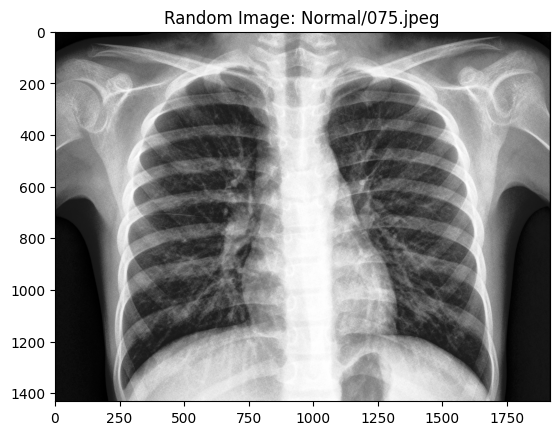

In [4]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# Set the path to the train dataset folder
train_folder = '/gdrive/MyDrive/Covid19-dataset/train'

# Get the list of sub-folders within the train folder
sub_folders = [folder for folder in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, folder))]

# Choose a random sub-folder
if len(sub_folders) > 0:
    random_sub_folder = random.choice(sub_folders)
    sub_folder_path = os.path.join(train_folder, random_sub_folder)

    # Get the list of image files in the selected sub-folder
    image_files = [file for file in os.listdir(sub_folder_path) if os.path.isfile(os.path.join(sub_folder_path, file))]

    # Choose a random image file from the list for display
    if len(image_files) > 0:
        random_image_file = random.choice(image_files)
        random_image_path = os.path.join(sub_folder_path, random_image_file)

        # Read and display the random image
        random_image = cv2.cvtColor(cv2.imread(random_image_path), cv2.COLOR_BGR2RGB)
        plt.imshow(random_image)
        plt.title(f"Random Image: {os.path.join(random_sub_folder, random_image_file)}")
        plt.show()
    else:
        print(f"No image files found in the {random_sub_folder} sub-folder.")
else:
    print("No sub-folders found in the train dataset.")


### **Question 1: Apply PCA to the images from folder '360 Rocks'. How many components do you need to preserve 95% of the variance?**

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image

def load_and_preprocess_images(folder_path, target_size=(800, 800)):
    images = []

    # Recursively loop through files in the folder and its sub-folders
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)

            # Check if the file is an image
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                img = Image.open(file_path)
                img = img.convert('L')  # Convert images to grayscale
                img = img.resize(target_size)  # Resize images to a common size
                img_array = np.array(img)  # Convert image to numpy array
                images.append(img_array)

    return images

def apply_pca(images, variance_threshold=0.95):
    n_images = len(images)
    image_size = images[0].shape[0] * images[0].shape[1]

    # Flatten grayscale images into a 2D format
    image_data = np.array(images).reshape(n_images, image_size)

    pca = PCA()
    pca.fit(image_data)

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    n_components = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

    # Apply PCA with the specified number of components (n_components)
    pca_reduced = PCA(n_components=n_components)
    pca_reduced.fit(image_data)

    return n_components, pca_reduced  # Return the reduced PCA model


# Set the path to the train dataset folder
train_folder = '/gdrive/MyDrive/Covid19-dataset/train'

images = load_and_preprocess_images(train_folder)
n_components, pca = apply_pca(images, variance_threshold=0.95)
print(f"Number of components to preserve 95% of the variance: {n_components}")


Number of components to preserve 95% of the variance: 125


PCA (Principal Component Analysis) has successfully reduced the dimensionality of the original images. By retaining 125 principal components, we preserve 95% of the total variance in the data.

### **Question 2: Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 95% of variance using PCA.**

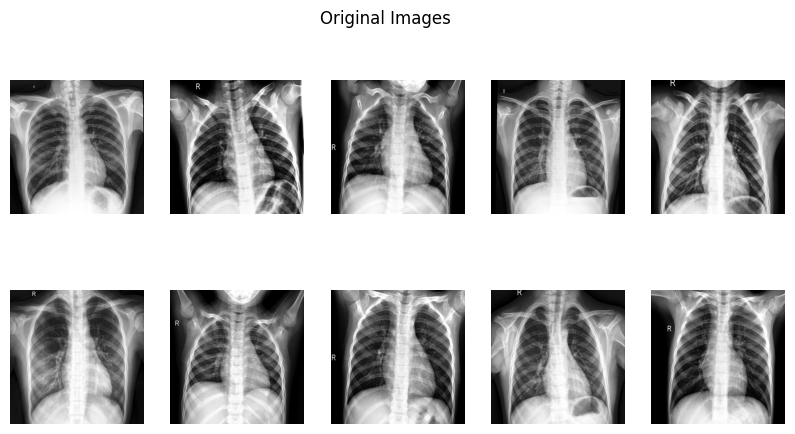

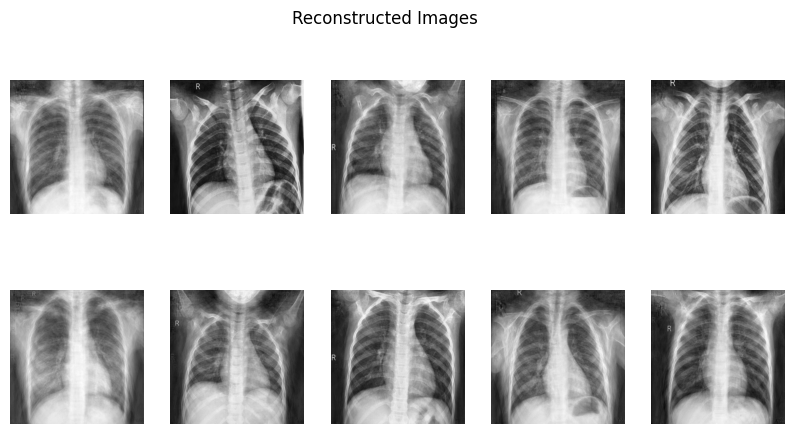

In [9]:
def plot_images(images, n_images, title, num_rows, num_cols):
    plt.figure(figsize=(10, 5))
    plt.suptitle(title)

    for i in range(n_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')


# Plot 10 original images
n_images_to_plot = 10
original_images = images[:n_images_to_plot]
plot_images(original_images, n_images_to_plot, title='Original Images', num_rows=2, num_cols=5)
plt.show()

# Reconstruct the images using PCA
flattened_original_images = np.array(original_images).reshape(n_images_to_plot, -1)
reconstructed_images = pca.inverse_transform(pca.transform(flattened_original_images))

# Plot 10 reconstructed images
plot_images(reconstructed_images.reshape(n_images_to_plot, *original_images[0].shape), n_images_to_plot, title='Reconstructed Images', num_rows=2, num_cols=5)
plt.show()


### **Question 3: Each of the images belongs to one of three categories. The category is indicated by the first part of the in the filename (Covid, Normal and Viral Pnemonia). We will now try to see if the visualization can help us identify different clusters.**

**A. Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components?**

In [10]:
X = []
Z = []
IMG_SIZE = 224

# Update the directories based on your folder structure
Train_Covid_dir = '/gdrive/MyDrive/Covid19-dataset/train/Covid'
Train_Normal_dir = '/gdrive/MyDrive/Covid19-dataset/train/Normal'
Train_Viral_dir = '/gdrive/MyDrive/Covid19-dataset/train/Viral Pneumonia'


In [11]:
def assign_label(img,xray_type):
    return xray_type

def make_train_data(xray_type, DIR):
    for img in tqdm(os.listdir(DIR)):
        label = assign_label(img, xray_type)
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)

        # Convert the image to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize the image
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

make_train_data('Covid',Train_Covid_dir)
print(len(X))

make_train_data('Normal',Train_Normal_dir)
print(len(X))

make_train_data('Viral Pneumonia',Train_Viral_dir)
print(len(X))


100%|██████████| 111/111 [00:06<00:00, 17.27it/s]


111


100%|██████████| 70/70 [00:05<00:00, 13.87it/s]


181


100%|██████████| 70/70 [00:03<00:00, 22.53it/s]

251


In [14]:
# Apply PCA to the original images
X_array = np.array(X)
X_flat = X_array.reshape(X_array.shape[0], -1)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_flat)
pca = PCA(n_components=n_components)  # Use the calculated number of components
X_pca = pca.fit_transform(X_standardized)

In [15]:

# Standardize the data
X_array = np.array(X)
X_flat = X_array.reshape(X_array.shape[0], -1)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_flat)

# Apply PCA with 2 components
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_standardized)

# Calculate the explained variance ratio for the first two components
explained_variance_ratio_2d = pca.explained_variance_ratio_

print("Explained variance ratio for the first two components:", explained_variance_ratio_2d)


Explained variance ratio for the first two components: [0.19507522 0.10458241]


In [16]:
total_variance_explained_2d = np.sum(explained_variance_ratio_2d)
print("Total Variance Explained by the First Two Components:", total_variance_explained_2d)



Total Variance Explained by the First Two Components: 0.2996576360144909


By identifying from the code, the total variance required by the first two components is 0.2996576360144909, which approximates to 30%.

### **B. Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image category (so you will have three different colors). Then add some rock images to the visualization to better understand what features in the images are accounting for the majority of variance in the data (your visualization should look similar to the one after line 71 in this file https://github.com/ageron/handson-ml3/blob/main/08_dimensionality_reduction.ipynbLinks to an external site. but with images of rocks instead of MNIST digits). Repeat the process and create the same type of plots for t-SNE, LLE and MDS.**

<ipython-input-17-9756df06f59f>:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_2d[indices, 0], X_2d[indices, 1], label=category, c=color, alpha=0.7)


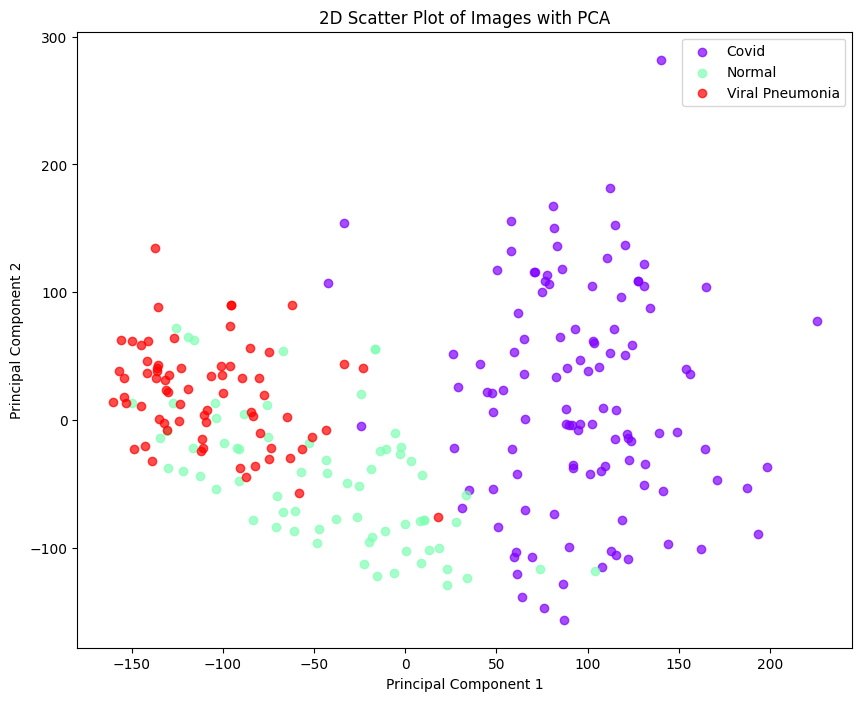

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot 2D scatter plot
def plot_2d_scatter(X_2d, labels, categories, category_colors):
    plt.figure(figsize=(10, 8))

    for category, color in zip(categories, category_colors):
        indices = [i for i, label in enumerate(labels) if label == category]
        plt.scatter(X_2d[indices, 0], X_2d[indices, 1], label=category, c=color, alpha=0.7)

    plt.title('2D Scatter Plot of Images with PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

# Categories and their corresponding colors
categories = np.unique(Z)
category_colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))

# Create a dictionary to store indices for each class
class_indices = {class_name: [] for class_name in np.unique(Z)}

# Populate class_indices with indices for each class
for i, class_name in enumerate(Z):
    class_indices[class_name].append(i)

# Select all available indices for each class
selected_indices = [index for indices in class_indices.values() for index in indices]

X_pca_2d_filtered = X_pca_2d[selected_indices]
Z_values_2d_filtered = np.array(Z)[selected_indices]

plot_2d_scatter(X_pca_2d_filtered, Z_values_2d_filtered, categories, category_colors)


### **Adding images to the 2D plot**

<ipython-input-18-f42249081597>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_2d[indices, 0], X_2d[indices, 1], label=category, c=color, alpha=0.5, s=70)  # Adjust the s parameter for dot size


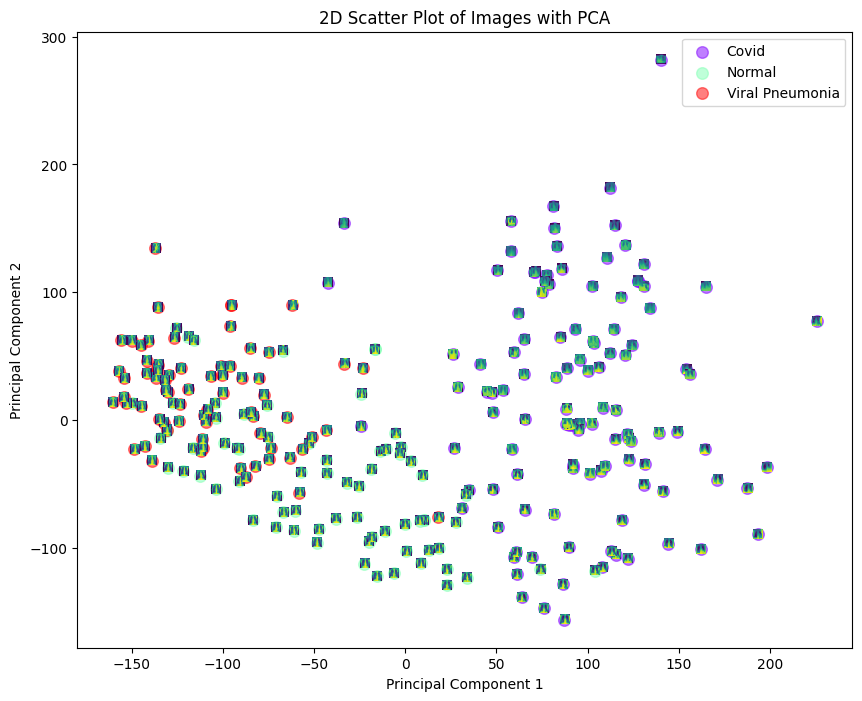

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Function to plot 2D scatter plot with images
def plot_2d_scatter_with_images(X_2d, labels, categories, category_colors, images):
    fig, ax = plt.subplots(figsize=(10, 8))

    for category, color in zip(categories, category_colors):
        indices = [i for i, label in enumerate(labels) if label == category]
        ax.scatter(X_2d[indices, 0], X_2d[indices, 1], label=category, c=color, alpha=0.5, s=70)  # Adjust the s parameter for dot size

        for i in indices:
            imagebox = OffsetImage(images[i], zoom=0.03, resample=True)  # Adjust the zoom parameter to control image size
            ab = AnnotationBbox(imagebox, (X_2d[i, 0], X_2d[i, 1]), frameon=False, pad=0, xycoords='data', boxcoords="data")
            ax.add_artist(ab)

    ax.set_title('2D Scatter Plot of Images with PCA')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.legend()
    plt.show()

# Assuming X_pca_2d_filtered and Z_values_2d_filtered are defined
categories = np.unique(Z_values_2d_filtered)
category_colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))

# Plot 2D scatter plot with larger dot size
plot_2d_scatter_with_images(X_pca_2d_filtered, Z_values_2d_filtered, categories, category_colors, X)


### **Generating the plot for t-SNE**

<ipython-input-18-f42249081597>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_2d[indices, 0], X_2d[indices, 1], label=category, c=color, alpha=0.5, s=70)  # Adjust the s parameter for dot size


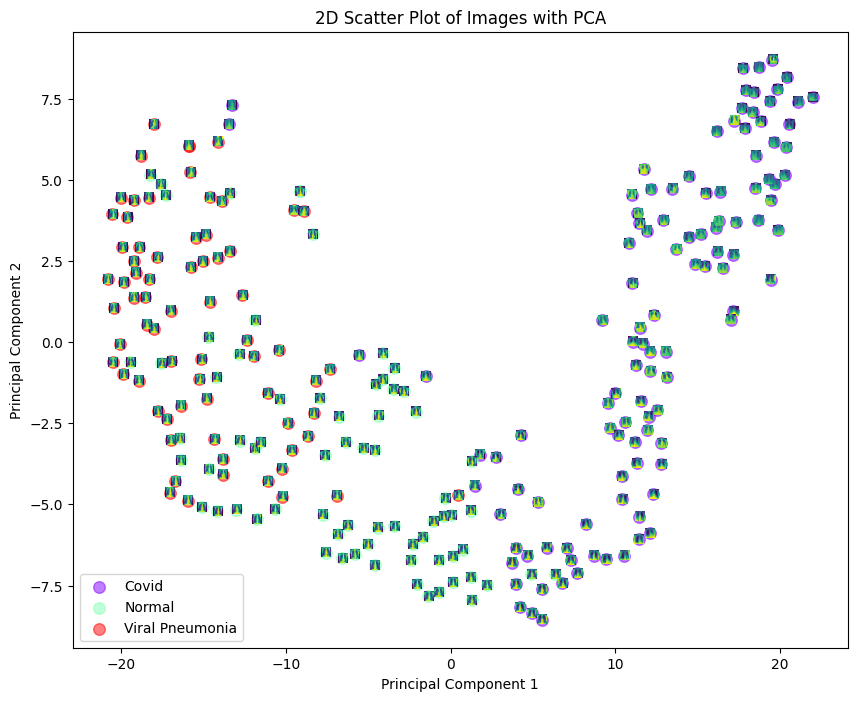

In [19]:
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS

#Perform t-SNE
tsne = TSNE(n_components=n_components, random_state=42)
X_tsne_2d_filtered = tsne.fit_transform(X_pca_2d_filtered)


# Plot t-SNE scatter plot
plot_2d_scatter_with_images(X_tsne_2d_filtered, Z_values_2d_filtered, categories, category_colors, X)




### **Generating the plot for LLE**

<ipython-input-18-f42249081597>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_2d[indices, 0], X_2d[indices, 1], label=category, c=color, alpha=0.5, s=70)  # Adjust the s parameter for dot size


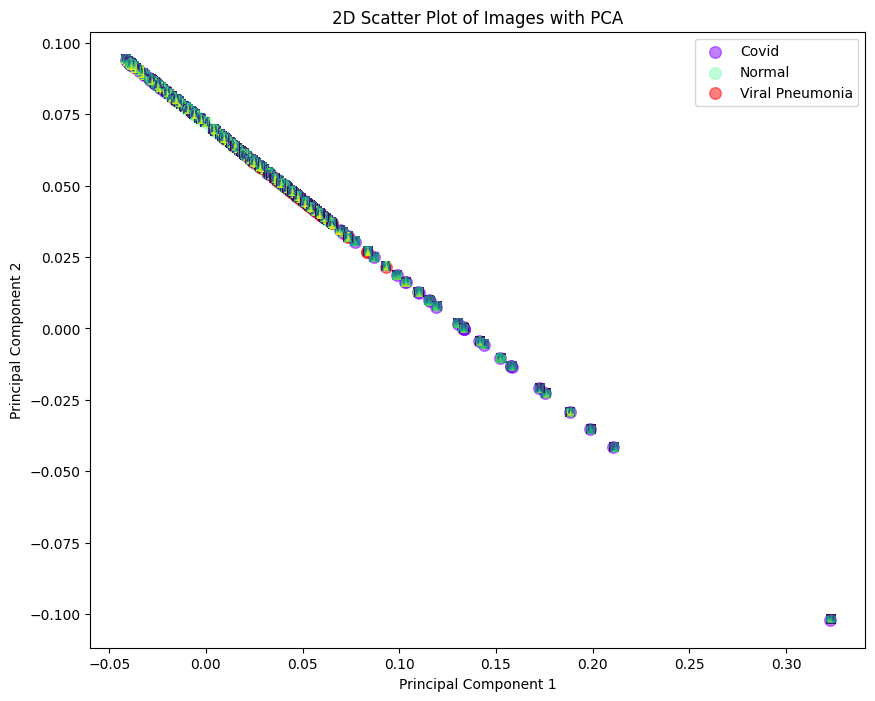

In [34]:
# Perform LLE
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_lle_2d_filtered = lle.fit_transform(X_pca_2d_filtered)

# Plot LLE scatter plot
plot_2d_scatter_with_images(X_lle_2d_filtered, Z_values_2d_filtered, categories, category_colors, X)



### **Generating the plot for MDS**

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
<ipython-input-18-f42249081597>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_2d[indices, 0], X_2d[indices, 1], label=category, c=color, alpha=0.5, s=70)  # Adjust the s parameter for dot size


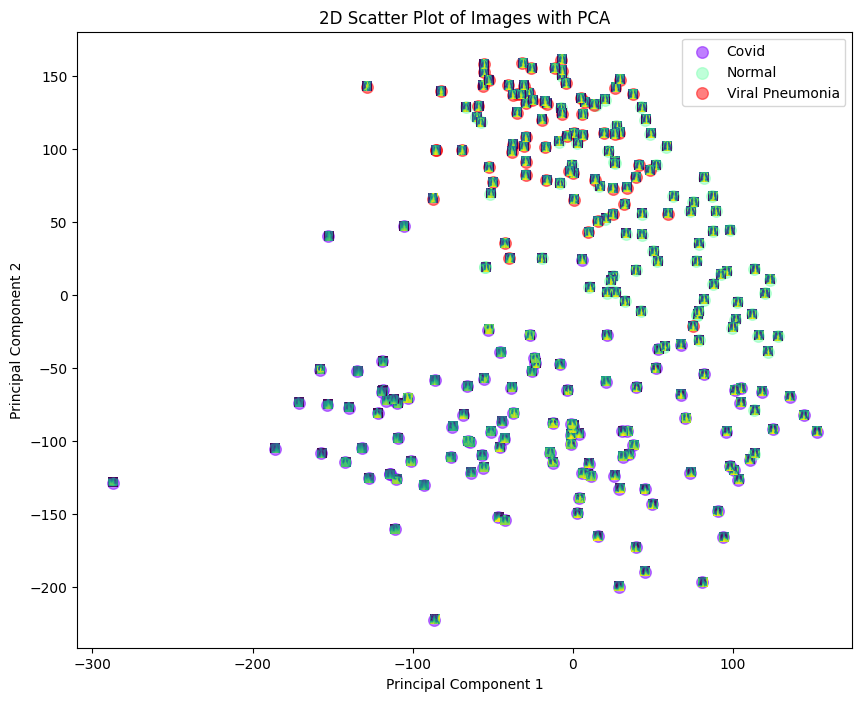

In [21]:
# Perform MDS
mds = MDS(n_components=2, random_state=42)
X_mds_2d_filtered = mds.fit_transform(X_pca_2d_filtered)

# Plot MDS scatter plot
plot_2d_scatter_with_images(X_mds_2d_filtered, Z_values_2d_filtered, categories, category_colors, X)




### **C. What visualizations would you prefer?**

We can analyze the 4 visualizations above:

1. **The PCA plot:** While the PCA is able to distinctly identify the images belong the Covid cluster, it finds it diificult to seperate the images that correspond to the Normal and Viral Pneumonia.
2. **t-SNE plot:** t-SNE excels in preserving local relationships, resulting in well-separated clusters. Nevertheless, it may introduce some overlapping points. This is reflected in the imaged corresponding to the Normal and Viral Pneumonia. Overall, it manages to cluster in a decent manner.
3. **LLE plot:** LLE is a nonlinear dimensionality reduction technique that aims to preserve local relationships in the data. If the data is distributed in such a way that the local relationships are effectively captured by a linear structure, the LLE plot might appear as a straight line. In other words, if the underlying structure of your data is essentially linear in the reduced dimensionality that LLE is trying to capture. Hence, LLE is unable to cluster the images into the 3 clusters.
4. **MDS plot:** MDS aims to preserve the pairwise distances between data points in the original space. However, it is unable to cluster the images well, which could be due to outliers, non-linear data or ambiguity in the distances between data points. 


After evaluating the visualizations, we can confirm that t-SNE performs a decent job in clustering the images into the categories as compared to the other techniques. Hence , the t-SNE visualization would be preferred.

### **Question 5**

### **A.** Cluster the 360 images using K-Means.To speed up the algorithm, use PCA to reduce the dimensionality of the dataset to two. Determine the number of clusters using one of the techniques we discussed in class.

Identifying the clusters using the Elbow method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

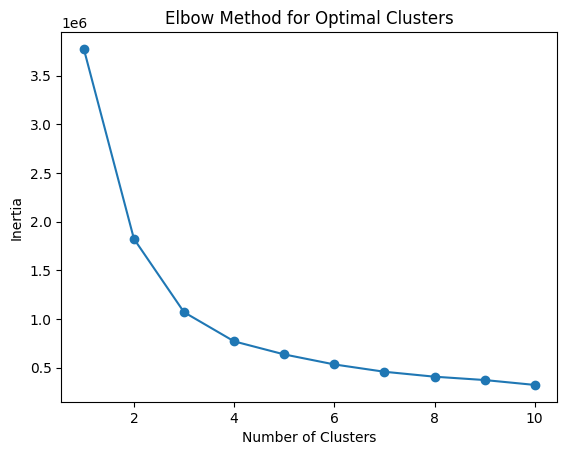

In [22]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

X_array = np.array(X)
X_flat = X_array.reshape(X_array.shape[0], -1)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_flat)


pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_standardized)

# Determine the optimal number of clusters using the elbow method
inertia = []
possible_clusters = range(1, 11)  # You can adjust the range based on your data
for n_clusters in possible_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X_pca_2d)
    inertia.append(kmeans.inertia_)

# Plot the elbow method to help determine the optimal number of clusters
plt.plot(possible_clusters, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()
plt.show()


The code utilizes the elbow method to identify the appropriate value for k, the number of clusters. This method involves computing the inertia for a range of potential k values, typically ranging from 2 to 10. The elbow method assists in identifying the inflection point where further increasing the number of clusters no longer significantly reduces inertia. The code generates an elbow plot to illustrate how inertia changes across different k values. Following this analysis, K-Means clustering is performed with the optimal number of clusters determined by the elbow method.

Based on the above visualization we can identify that the ideal number of clusters would be 3, which matches the classes in the dataset.

In [23]:
X_pca.shape

(251, 125)

### **B. Visualizing the clusters**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


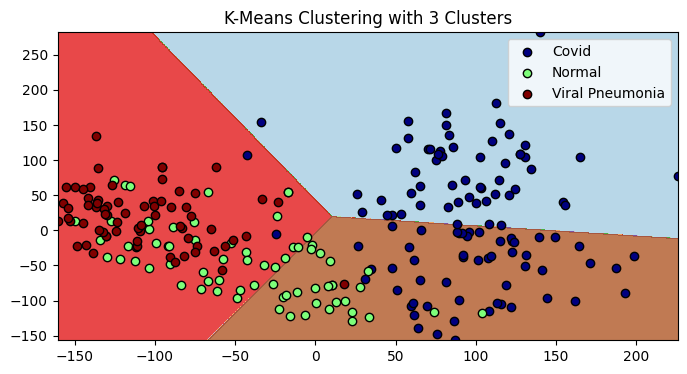

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def plot_decision_boundaries(kmeans, X):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 1000),
                         np.linspace(mins[1], maxs[1], 1000))
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundaries
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

Xray_names = Z
label_mapping = {name: i for i, name in enumerate(np.unique(Xray_names))}
labels = np.vectorize(label_mapping.get)(Xray_names)


kmeans = KMeans(n_clusters=3, random_state=0)
kmeans_labels = kmeans.fit_predict(X_pca_2d)


plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X_pca_2d)

# Scatter points based on the cluster labels with flower names
unique_labels = np.unique(Xray_names)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
for i, label in enumerate(unique_labels):
    X_cluster = X_pca_2d[labels == label_mapping[label]]
    plt.scatter(X_cluster[:, 0], X_cluster[:, 1], label=label, c=[colors[i]], edgecolor='k')

plt.title(f'K-Means Clustering with {kmeans.n_clusters} Clusters')
plt.legend()
plt.show()


The K-means algorithm will have identified three centroids, each serving as the center of one of the clusters. These centroids are calculated based on the features extracted from the medical images, and their positions indicate the average characteristics of images within each category.The clusters are expected to be spatially separated, reflecting the distinctive features of each medical condition. Ideally, Covid cases, Normal cases, and Viral Pneumonia cases should form distinct groups, demonstrating that the algorithm has successfully identified and separated different patterns in the data.

However, based on the visualization above, we can notice that the K-means algorithm finds it challenging to accurately cluster the data while preserving 30% of the variance. One of the reasons for this could be the inherent data structure, where if the data has a complex structure that cannot be well-represented by simple clusters, K-means might not be the most suitable algorithm for the task.

### **Question 6**

**A. Cluster the images using EM. Same as in the previous question, to speed up the algorithm, use PCA to reduce the dimensionality of the dataset to two. Determine the number of clusters using one of the techniques we discussed in class.**

The best n components: 2
Optimal number of components: 2


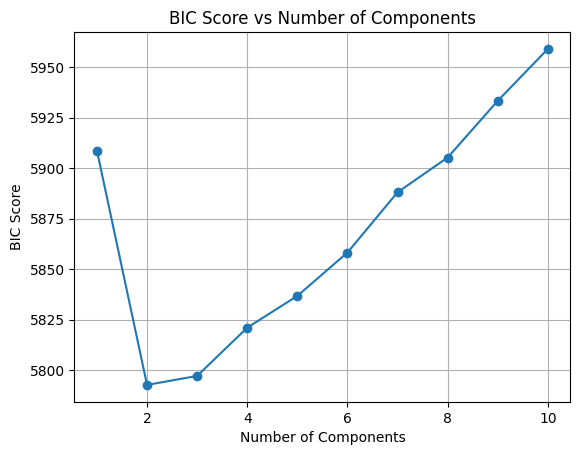

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler


def calculate_bic_scores(X, range_n_components):
    bic_scores = []
    for n in range_n_components:
        gmm = GaussianMixture(n_components=n, random_state=0)
        gmm.fit(X)
        bic = gmm.bic(X)
        bic_scores.append(bic)
    return bic_scores

range_n_components = range(1, 11)
bic_scores = calculate_bic_scores(X_pca_2d, range_n_components)

# Find the optimal number of components with the lowest BIC score
best_n_components = range_n_components[np.argmin(bic_scores)]
print("The best n components:", best_n_components)

# Plot BIC scores
print(f"Optimal number of components: {best_n_components}")
plt.plot(range_n_components, bic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Score vs Number of Components')
plt.grid(True)
plt.show()



BIC scores were calculated across a range of component numbers (2 to 10) using a Gaussian Mixture Model (GMM) with full covariance. The resulting BIC scores plot visually illustrates their fluctuations with varying component numbers. When determining the optimal number of components for a Gaussian Mixture Model, the decision hinges on the Bayesian Information Criterion (BIC), favoring the model with the lowest BIC score. Upon visualization, it was noted that the model with 2 components exhibited the minimum BIC score, signifying the most favorable balance between model fit and complexity. Consequently, 2 was identified as the optimal number of clusters for the given dataset.


**B. Visualize the clusters in a similar way**

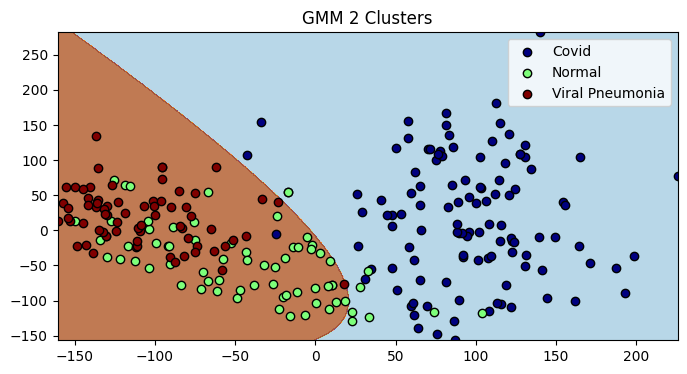

In [26]:
gmm = GaussianMixture(n_components=best_n_components, random_state=0)
gmm.fit(X_pca_2d)

Xray_names = Z
label_mapping = {name: i for i, name in enumerate(np.unique(Xray_names))}
labels = np.vectorize(label_mapping.get)(Xray_names)

gmm_labels = gmm.predict(X_pca_2d)
# Plot the decision boundaries for the clusters
plt.figure(figsize=(8, 4))
plot_decision_boundaries(gmm, X_pca_2d)

unique_labels = np.unique(Xray_names)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
for i, label in enumerate(unique_labels):
    X_cluster = X_pca_2d[labels == label_mapping[label]]
    plt.scatter(X_cluster[:, 0], X_cluster[:, 1], label=label, c=[colors[i]], edgecolor='k')

plt.title(f'GMM {best_n_components} Clusters')
plt.legend()
plt.show()

The visualization involves examining how well the GMM captures the inherent structure of the data. The clusters should align with the ground truth labels (Covid, Normal, Viral Pneumonia). While this visualization performs a decent task in clustering the COvid images, it find it difficult to seperate images from Normal and Viral Pneumonia.

**C. Use the model to generate 20 new images (using the sample() method), and visualize them in the original image space (since you used PCA, you will need to use its inverse_transform() method).**

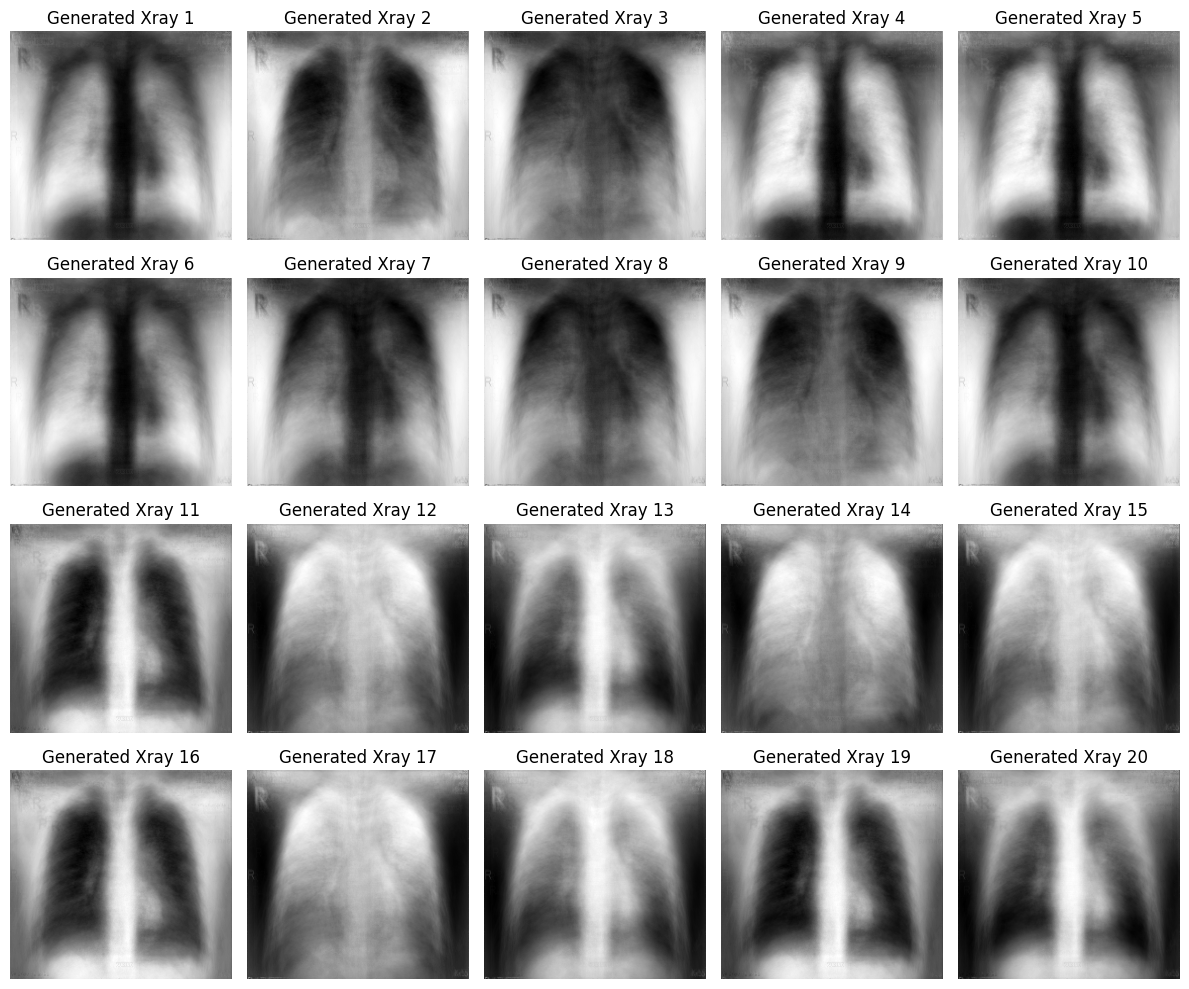

In [27]:
def generate_and_visualize_new_rocks(gmm, pca, n_samples=20, original_image_shape=(224, 224)):
    # Generate samples from the GMM
    generated_samples, _ = gmm.sample(n_samples=n_samples)  # Use the first element of the tuple
    original_samples = pca.inverse_transform(generated_samples)

    # Visualize the generated images
    fig, axes = plt.subplots(4, 5, figsize=(12, 10))
    for i, ax in enumerate(axes.ravel()):
        # Reshape to match the original image dimensions
        ax.imshow(original_samples[i].reshape(original_image_shape), cmap='gray', aspect='auto')
        ax.axis('off')
        ax.set_title(f'Generated Xray {i+1}')

    plt.tight_layout()
    plt.show()

# 'gmm' is your trained Gaussian Mixture Model and 'pca' is the PCA model you applied
generate_and_visualize_new_rocks(gmm, pca, n_samples=20)


### **Question 7**

Getting the training and test data from the folder and applied data augmentation to the data.

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
import time

train_folder = "/content/sample_data/Covid19-dataset/train"
test_folder = "/content/sample_data/Covid19-dataset/test"

batch_size = 32  # Set your desired batch size

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   vertical_flip=True,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                  )
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size=(64, 64),
                                                 batch_size=batch_size,
                                                 class_mode='sparse'  # For sparse categorical crossentropy
                                                 )

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size=(64, 64),
                                            batch_size=batch_size,
                                            class_mode='sparse'
                                            )



Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


Building the sequential model

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
import time

train_folder = "/gdrive/MyDrive/Covid19-dataset/train"
test_folder = "/gdrive/MyDrive/Covid19-dataset/test"

batch_size = 32  # Set your desired batch size

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   vertical_flip=True,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                  )
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size=(64, 64),
                                                 batch_size=batch_size,
                                                 class_mode='sparse'  # For sparse categorical crossentropy
                                                 )

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size=(64, 64),
                                            batch_size=batch_size,
                                            class_mode='sparse'
                                            )


###Works decent with training and validation loss
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'],
              loss='sparse_categorical_crossentropy'
              )

# Callback to record training time
class TimingCallback(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.start_time = time.time()

    def on_train_end(self, logs={}):
        self.end_time = time.time()
        self.training_time = self.end_time - self.start_time
        print(f"Training time: {self.training_time} seconds")

# Training with data augmentation
history = callbacks.History()
timing_callback = TimingCallback()

model.fit(training_set,
          epochs=30,
          callbacks=[history, timing_callback],
          steps_per_epoch=len(training_set),
          validation_data=test_set,
          verbose=1
          )


Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Epoch 1/30
8/8 [==============================] - 37s 5s/step - loss: 0.9753 - accuracy: 0.5618 - val_loss: 0.8806 - val_accuracy: 0.5455
Epoch 2/30
8/8 [==============================] - 13s 2s/step - loss: 0.6495 - accuracy: 0.7131 - val_loss: 0.8070 - val_accuracy: 0.6364
Epoch 3/30
8/8 [==============================] - 9s 1s/step - loss: 0.5556 - accuracy: 0.8008 - val_loss: 0.8142 - val_accuracy: 0.6515
Epoch 4/30
8/8 [==============================] - 12s 1s/step - loss: 0.4222 - accuracy: 0.8446 - val_loss: 0.8036 - val_accuracy: 0.6212
Epoch 5/30
8/8 [==============================] - 12s 2s/step - loss: 0.3732 - accuracy: 0.8845 - val_loss: 0.8617 - val_accuracy: 0.5455
Epoch 6/30
8/8 [==============================] - 9s 1s/step - loss: 0.3713 - accuracy: 0.8566 - val_loss: 0.7856 - val_accuracy: 0.6061
Epoch 7/30
8/8 [==============================] - 12s 2s/step - loss: 0.3128 - accuracy: 0.88

### **A. Report the training time (use code to do this).**

Training time: 496.4964077472687 seconds

### **B. Plot training and validation loss and accuracy as a function of training epochs.**

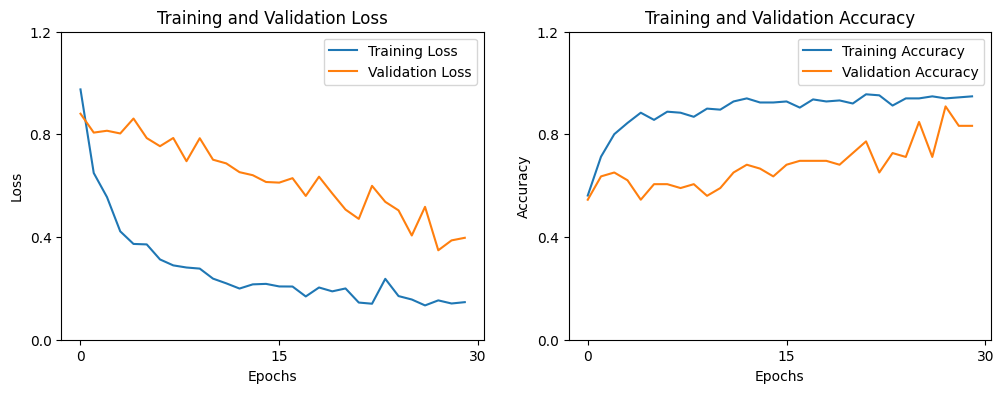

In [29]:
import numpy as np

plt.figure(figsize=(12, 4))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(0, len(history.history['loss']) + 1, 15))
plt.yticks(np.arange(0, max(history.history['loss']) + 0.4, 0.4))  # Set y-ticks with an interval of 0.4

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(0, len(history.history['loss']) + 1, 15))
plt.yticks(np.arange(0, 1.0 + 0.4, 0.4))  # Set y-ticks with an interval of 0.4

plt.show()


### **C. How many parameters does the network have? How many of those parameters are bias parameters?**

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 64)                1968192   
                                                                 
 dense_1 (Dense)             (None, 8)                 5

We can analyze the model based on each layer as follows:

- Conv2D Layer (conv2d): The convolutional layer has 32 filters of size (3, 3), and each filter has its own bias parameter. So, the total number of bias parameters for this layer is 32.

- BatchNormalization Layer (batch_normalization): BatchNormalization does not have bias parameters as it normalizes based on the learned scale and shift parameters.

- Dense Layer (dense): The first dense layer has 64 units with ReLU activation. Each unit has its own bias parameter. So, the total number of bias parameters for this layer is 64.

- Dense Layer (dense_1): The second dense layer has 8 units with ReLU activation. Each unit has its own bias parameter. So, the total number of bias parameters for this layer is 8.

- Dense Layer (dense_2): The output layer has 3 units with softmax activation. Each unit has its own bias parameter. So, the total number of bias parameters for this layer is 3.

Adding up these numbers, the total number of bias parameters is 32 + 64 + 8 + 3 = 107.

So, the network has a total of 1,969,699 parameters, and out of these, 1,969,635 are trainable parameters, and 107 are non-trainable bias parameters.









#### Notes:

- The current CNN model although ensures that the loss function is decreasing with every epoch and the accuracy is increasing with the epoch, the training model can be found to be overfitting and the small dataset could be one the major reasons. There were multiple approaches tried such as increasing the complexity, trying different batch sizes or learning rates. This model worked best with this dataset.

- For future work, the model would work well with increased dataset. The dataset used for training the model is small, with additional data we could work with increased complexity of the model and expected the loss and accuracy function to converge.

- Additionally, we could try different model using transfer learning such as VGG-19 or VGG-16, which could work well while training the dataset.